# Emotion Classification by Face Segments using Transfer Learning


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/DS301_FinalProject/facial_expression_dataset.zip

In [ ]:
%cd /content

/content


In [ ]:
%mkdir fer_2013
%cd fer_2013

/content/fer_2013


In [ ]:
!unzip /content/gdrive/MyDrive/DS301_FinalProject/fer_2013.zip

#Training the Base Model

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

## Inspect the base dataset

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
# trainset -> original data set, in the object of tensorflow batchdataset
# This is only used in inspecting image data
# traingen and valgen are used in training
trainset = keras.utils.image_dataset_from_directory("/content/fer_2013/train",
                                                    labels='inferred',
    label_mode='categorical',
    class_names = {"surprise":"Surprise",
                   "fear":"Fear",
                   "disgust":"Disgust",
                   "happy":"Happiness",
                   "sad":"Sadness",
                   "angry":"Anger",
                   "neutral":"Neutral"})


# Use Image data generator to preprocess images 
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    validation_split=0.2)
traingen = datagen.flow_from_directory("/content/fer_2013/train",target_size = [48,48],subset = "training",color_mode='rgb')
valgen = datagen.flow_from_directory("/content/fer_2013/train",target_size = [48,48],subset = "validation",color_mode='rgb')


Found 28709 files belonging to 7 classes.
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
trainset.class_names

{'angry': 'Anger',
 'disgust': 'Disgust',
 'fear': 'Fear',
 'happy': 'Happiness',
 'neutral': 'Neutral',
 'sad': 'Sadness',
 'surprise': 'Surprise'}

Text(0.5, 0, 'class_names')

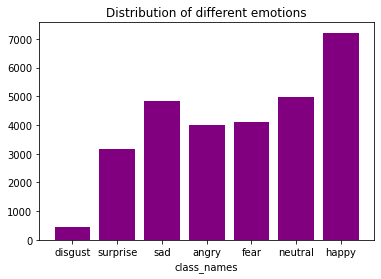

In [ ]:
# plot the distribution of images
num_of_images = []
name_of_classes=[]

for a_class in os.listdir("/content/fer_2013/train"):
  num_of_images += [len(os.listdir("/content/fer_2013/train/"+a_class))]
  name_of_classes += [os.path.basename(a_class)]
class_names = list(trainset.class_names.keys())

plt.figure()
plt.bar(name_of_classes,num_of_images,color = "purple")
plt.title("Distribution of different emotions")
plt.xlabel("class_names")

In [ ]:
class_names

['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)


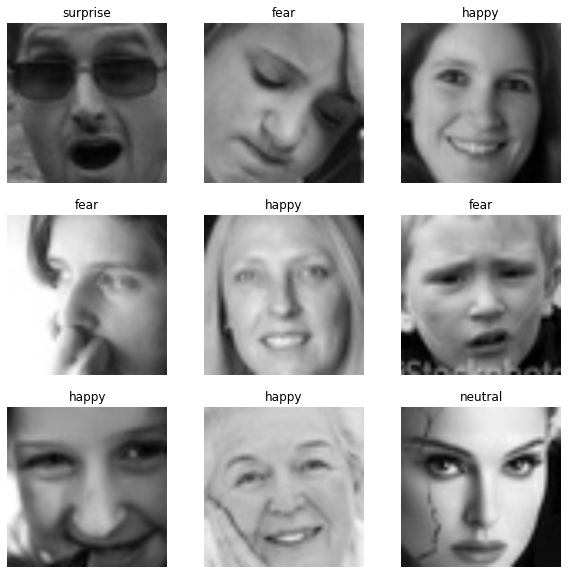

In [ ]:
# show sample images

for image, labels in trainset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print(labels[i])
    index = int(tf.where(labels[i]))
    plt.title(list(class_names)[index])
    ax.imshow(image[i] / 255)
    plt.axis('off')

In [ ]:
for image,label in traingen:
  print (image.shape)
  print (label.shape)
  break

  

(32, 48, 48, 3)
(32, 7)


## The Base Model

In [ ]:
%cd /content

/content


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Add,AveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
def emotion_classification_model(input_shape=(48,48,3), num_classes = 7):
    visible = Input(shape=input_shape, name='input')

    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
# create a learning rate scheduler
def multistep_scheduler(epochs, lr):
  if epochs in [30,50,75]:
    lr = 0.1*lr
  return lr
multistep_lr = tf.keras.callbacks.LearningRateScheduler(multistep_scheduler)

In [ ]:
# check pointing callback
checkpoint_path = "base_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)

In [ ]:
model = emotion_classification_model()
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
num_epochs = 50 
history = model.fit(traingen,
                    epochs=num_epochs,
                    validation_data=valgen,
                    verbose=1,
                    callbacks = [multistep_lr,checkpointing])

Epoch 1/50
718/718 [==============================] - ETA: 0s - loss: 2.2512 - accuracy: 0.2388
Epoch 1: saving model to base_model/cp.ckpt
718/718 [==============================] - 50s 50ms/step - loss: 2.2512 - accuracy: 0.2388 - val_loss: 1.8376 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 2/50
718/718 [==============================] - ETA: 0s - loss: 1.6207 - accuracy: 0.3544
Epoch 2: saving model to base_model/cp.ckpt
718/718 [==============================] - 37s 51ms/step - loss: 1.6207 - accuracy: 0.3544 - val_loss: 1.6078 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 3/50
718/718 [==============================] - ETA: 0s - loss: 1.4524 - accuracy: 0.4383
Epoch 3: saving model to base_model/cp.ckpt
718/718 [==============================] - 41s 57ms/step - loss: 1.4524 - accuracy: 0.4383 - val_loss: 1.7512 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 4/50
718/718 [==============================] - ETA: 0s - loss: 1.3411 - accuracy: 0.4840
Epoch 4: saving model to base_model/cp.ckpt
71

In [ ]:
# use this to record the predicted label to do the LIME explaination in the next section
first_batch_prediction = model(traingen[1][0],training = False)

In [ ]:
# save the model
model.save_weights('./base_model/base_model_final')

Text(0.5, 1.0, 'accuracy training the base model')

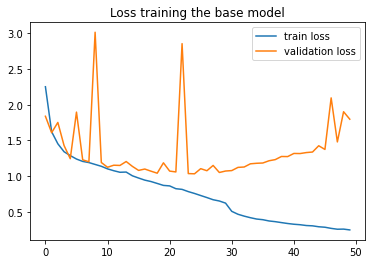

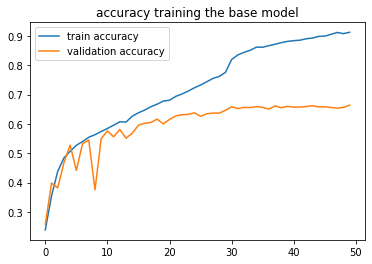

In [ ]:
# plot the accuracies and loss of trainset and val set
plt.figure()
length = len(history.history["loss"])
plt.plot(np.arange(length),history.history["loss"],label = "train loss")
plt.plot(np.arange(length),history.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("Loss training the base model")


plt.figure()
length = len(history.history["accuracy"])
plt.plot(np.arange(length),history.history["accuracy"],label = "train accuracy")
plt.plot(np.arange(length),history.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("accuracy training the base model")

## Construct LIME Explainer

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 31.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=7415d3ac0e814a5142298667d34b7e7845c8ed180982516eb452133a0ed78a17
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
traingen[0][1][1]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

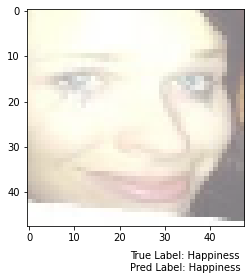

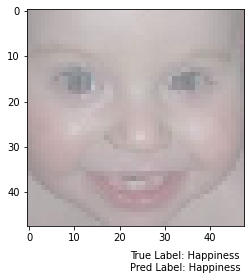

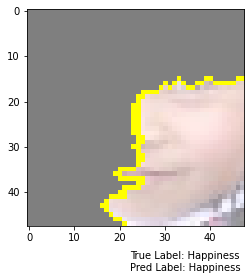

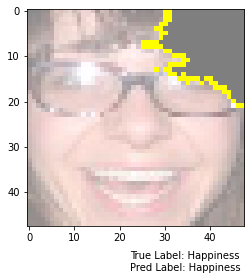

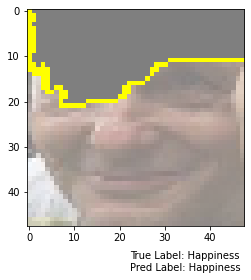

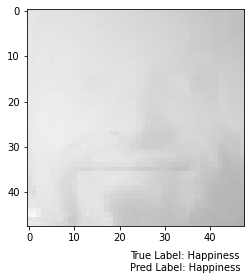

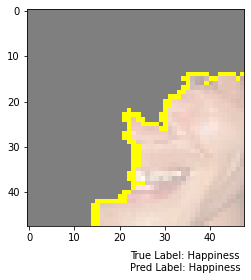

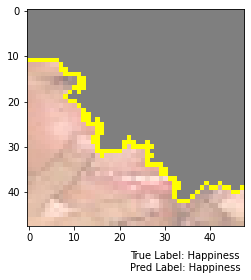

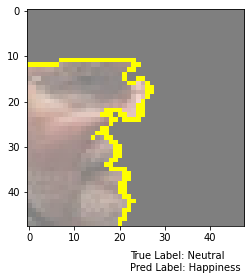

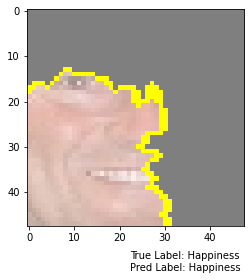

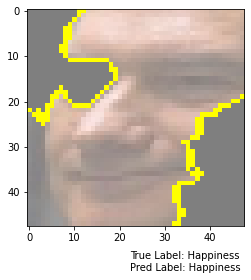

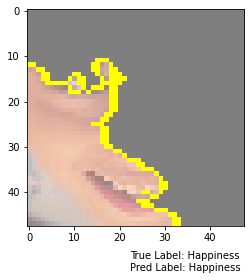

In [ ]:
for i in range(0,32):
  if np.argmax(first_batch_prediction[i]) == 3:
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(traingen[1][0][i].astype("double"), model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
    plt.figure()
    plt.figtext(0.5,0.01,"True Label: "+class_names[np.argmax(traingen[1][1][i])])
    plt.figtext(0.5,-0.03,"Pred Label: "+class_names[np.argmax(first_batch_prediction[i])])
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
print(explanation.local_exp)

{3: [(2, 0.8564207034914295), (1, 0.24176984190359566), (0, -0.01776912008692493)]}


#Training without class merging

## Crop the images

In [ ]:
# trainset -> original data set, in the object of tensorflow batchdataset
# This is only used in inspecting image data
# traingen and valgen are used in training
raf_trainset = keras.utils.image_dataset_from_directory("/content/facial_expression_dataset/train",
                                                    labels='inferred',
    label_mode='categorical',
    class_names = {"1":"Surprise",
                   "2":"Fear",
                   "3":"Disgust",
                   "4":"Happiness",
                   "5":"Sadness",
                   "6":"Anger",
                   "7":"Neutral"})




Found 12271 files belonging to 7 classes.


Text(0.5, 0, 'class_names')

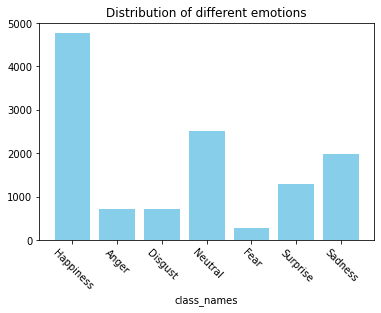

In [ ]:
# plot the distribution of images
num_of_images = []
name_of_classes=[]

for a_class in os.listdir("/content/facial_expression_dataset/train"):
  num_of_images += [len(os.listdir("/content/facial_expression_dataset/train/"+a_class))]
  name_of_classes += [os.path.basename(a_class)]
class_names = ["Surprise","Fear","Disgust","Happiness","Sadness","Anger","Neutral"]

plt.figure()
plt.bar(name_of_classes,num_of_images,color = "skyblue")
plt.title("Distribution of different emotions")
plt.xticks(["1","2","3","4","5","6","7"],class_names,rotation=-45)
plt.xlabel("class_names")

(48, 48, 3)


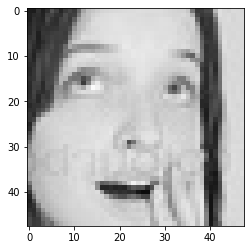

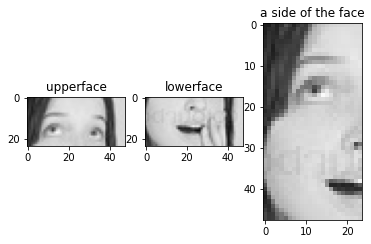

In [ ]:
# A reminder of traingen
# traingen[batch_number][0:image,1:label][the # of image or label][imagesize or class_name]
# crop_to_bounding_box(yStart,xStart,height,width)
print(traingen[0][0][0].shape)
side_length = int(traingen[0][0][0].shape[0])


plt.figure()
plt.imshow(traingen[0][0][0])

plt.figure()

sample_image = tf.image.crop_to_bounding_box(traingen[0][0][0],0,0,side_length//2,side_length)
ax1 = plt.subplot(1,3,1)
ax1.set_title("upperface")
ax1.imshow(sample_image)

sample_image = tf.image.crop_to_bounding_box(traingen[0][0][0],side_length//2,0,side_length//2,side_length)
ax2 = plt.subplot(1,3,2)
ax2.set_title("lowerface")
ax2.imshow(sample_image)

sample_image = tf.image.crop_to_bounding_box(traingen[0][0][0],0,0,side_length,side_length//2)
ax3 = plt.subplot(1,3,3)
ax3.set_title("a side of the face")
ax3.imshow(sample_image)

In [ ]:
side_length = 48
upper_mapfunc = lambda threeD_array: tf.image.resize_with_pad(tf.image.crop_to_bounding_box(threeD_array,0,0,side_length//2,side_length),48,48)

# Use Image data generator to preprocess images 
datagen_upper = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    preprocessing_function = upper_mapfunc,
    validation_split=0.2)
train_upper = datagen_upper.flow_from_directory("/content/facial_expression_dataset/train",target_size = [48,48],subset = "training")
val_upper = datagen_upper.flow_from_directory("/content/facial_expression_dataset/train",target_size = [48,48],subset = "validation")


Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.


IndexError: ignored

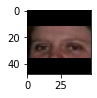

In [ ]:
for i in range(1,10):
  ax = plt.subplot(3,3,i)
  ax.imshow(train_upper[0][0][i+20])
  index = int(np.argmax(train_upper[0][1][i+20]))
  ax.set_title(class_names[index])
  plt.axis("off")

##Trai model without merging classes

In [ ]:
from tensorflow.keras.optimizers import schedules
# load the weight of the pretrained model but allow them to change
# use a different learning rate schedule

# initialize a cosine leaarning rat edecay schedule
cos_lr = schedules.CosineDecay(0.001, 1000, alpha=0.0)

# fine tuning
model_upper = emotion_classification_model()
opt_transfer = Adam(0.001)


model_upper.compile(loss='categorical_crossentropy', optimizer=opt_transfer, metrics=['accuracy'])
model_upper.load_weights("base_model/cp.ckpt")

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_102 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_103 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0  

In [ ]:
num_epochs = 30 
history = model_upper.fit(train_upper,
                    epochs=num_epochs,
                    validation_data=val_upper,
                    verbose=1)

Epoch 1/30
307/307 [==============================] - 61s 192ms/step - loss: 2.4604 - accuracy: 0.3245 - val_loss: 1.6766 - val_accuracy: 0.3679
Epoch 2/30
288/307 [===========================>..] - ETA: 3s - loss: 1.6422 - accuracy: 0.3891

KeyboardInterrupt: ignored

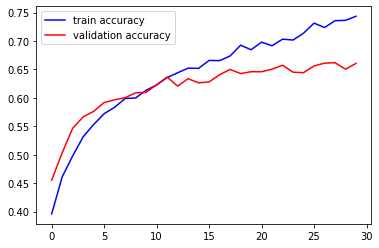

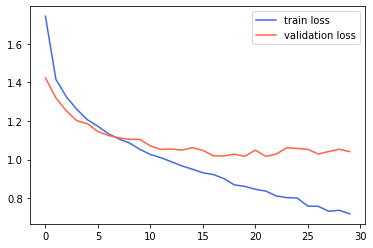

In [ ]:
plt.figure()
plt.plot(range(num_epochs),history.history["accuracy"],color = "blue",label="train accuracy")
plt.plot(range(num_epochs),history.history["val_accuracy"],color = "red",label="validation accuracy")
plt.legend()

plt.figure()
plt.plot(range(num_epochs),history.history["loss"],color = "royalblue",label="train loss")
plt.plot(range(num_epochs),history.history["val_loss"],color = "tomato",label="validation loss")
plt.legend()

In [ ]:
label_pred = model.predict(train_upper)
label_pred = np.argmax(label_pred,axis =1)
label_true = train_upper.classes

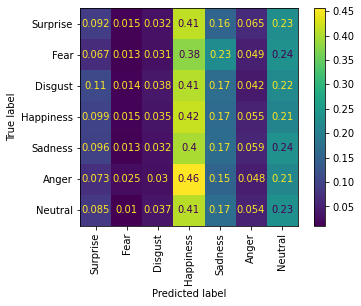

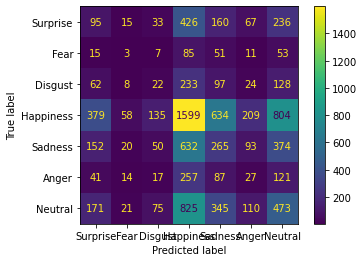

In [ ]:
# merge classes by checking confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

confusion_matrix = confusion_matrix(label_true,label_pred)

confusion_matrix_in_percentage = []
for each_class in confusion_matrix:
  each_class = each_class/np.sum(each_class)
  confusion_matrix_in_percentage += [each_class]

confusion_matrix_in_percentage = np.array(confusion_matrix_in_percentage)

confusion_plt = ConfusionMatrixDisplay(confusion_matrix_in_percentage,display_labels = class_names)
confusion_plt2 = ConfusionMatrixDisplay(confusion_matrix,display_labels = class_names)
confusion_plt.plot()
plt.xticks(rotation = 90)
confusion_plt2.plot()

plt.show()

Text(0.5, 6.79999999999999, "['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']")

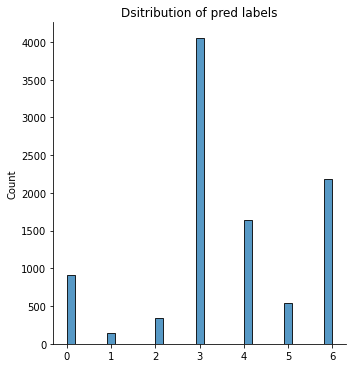

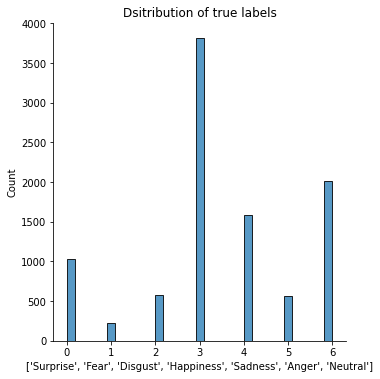

In [ ]:
import seaborn as sns

ax1 = sns.displot(label_pred)
plt.title("Dsitribution of pred labels")

ax2 = sns.displot(label_true)
plt.title("Dsitribution of true labels")
plt.xlabel(class_names)

##Combine Classes

In [ ]:
import os 
import shutil
src = "/content/facial_expression_dataset"
dst = "/content/facial_expression_dataset_combined"
shutil.copytree(src, dst, symlinks=False, ignore=None, copy_function=shutil.copy2, ignore_dangling_symlinks=False)

'/content/facial_expression_dataset_combined'

In [ ]:
class_names = ["Surprise","Fear","Disgust","Happiness","Sadness","Anger","Neutral"]
unhappy_classes = ["2/","3/","6/"]

destination_folder = "/content/facial_expression_dataset_combined/train/5/"

# trainset
for folder_name in unhappy_classes:
  source_folder = "/content/facial_expression_dataset_combined/train/"+folder_name
  for file_name in os.listdir(source_folder):
      # construct full file path
      source = source_folder + file_name
      destination = destination_folder + file_name
      # move only files
      if os.path.isfile(source):
          shutil.move(source, destination)
          print('Moved:', file_name)
  os.rmdir("/content/facial_expression_dataset_combined/train/"+folder_name)

In [ ]:
destination_folder = "/content/facial_expression_dataset_combined/test/5/"

# trainset
for folder_name in unhappy_classes:
  source_folder = "/content/facial_expression_dataset_combined/test/"+folder_name
  for file_name in os.listdir(source_folder):
      # construct full file path
      source = source_folder + file_name
      destination = destination_folder + file_name
      # move only files
      if os.path.isfile(source):
          shutil.move(source, destination)
          print('Moved:', file_name)
  os.rmdir("/content/facial_expression_dataset_combined/test/"+folder_name)

In [ ]:
shutil.rmtree("/content/facial_expression_dataset_combined/train/1")
shutil.rmtree("/content/facial_expression_dataset_combined/test/1")

In [ ]:
upper_mapfunc = lambda threeD_array: tf.image.resize_with_pad(tf.image.crop_to_bounding_box(threeD_array,0,0,side_length//2,side_length),48,48)
# Use Image data generator to preprocess images 
datagen_upper = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    preprocessing_function = upper_mapfunc,
    validation_split=0.2)

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.


In [ ]:
class_names = ["Happy","Unhappy","Neutral"]
train_upper = datagen_upper.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "training")
val_upper = datagen_upper.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "validation")

Found 8786 images belonging to 3 classes.
Found 2195 images belonging to 3 classes.


([<matplotlib.axis.XTick at 0x7fc0fe9427d0>,
 [Text(-0.25, 0, 'Happy'), Text(0.0, 0, 'Unhappy'), Text(0.25, 0, 'Neutral')])

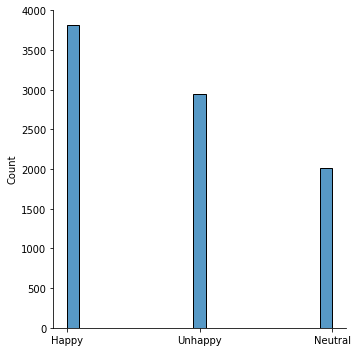

In [ ]:
import seaborn as sns
sns.displot(train_upper.classes)
plt.xticks([0,1,2],class_names)

# Train the upper model

##Train model with combined classes

In [289]:
# fine tuning
model_upper = emotion_classification_model(num_classes = 7)
opt_transfer = Adam(0.001)

model_upper.load_weights("base_model/cp.ckpt")

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_187 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_188 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0  

In [290]:
x = model_upper.layers[-1].output
predictions = Dense(3, activation = "softmax")(x)
model_upper = Model(inputs = model_upper.input, outputs = predictions)

In [291]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [292]:
# check pointing callback
checkpoint_path = "upper_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)

In [293]:
# create a learning rate scheduler
def multistep_scheduler2(epochs, lr):
  if epochs in [3,10]:
    lr = lr/5
  return lr
multistep_lr2 = tf.keras.callbacks.LearningRateScheduler(multistep_scheduler2)

In [294]:
def multistep_scheduler3(epochs, lr):
  if epochs==4 :
    lr = lr*0.1
  if epochs == 20:
    lr = lr/5
  return lr
multistep_lr3 = tf.keras.callbacks.LearningRateScheduler(multistep_scheduler3)

In [295]:
model_upper.compile(loss='categorical_crossentropy', optimizer=opt_transfer, metrics=['accuracy'])
num_epochs = 30
history = model_upper.fit(train_upper,
                    epochs=num_epochs,
                    validation_data=val_upper,
                    verbose=1,
                    callbacks = [multistep_lr3, checkpointing])

Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.5557
Epoch 1: val_loss improved from inf to 0.96169, saving model to upper_model/cp.ckpt
275/275 [==============================] - 66s 233ms/step - loss: 0.9737 - accuracy: 0.5557 - val_loss: 0.9617 - val_accuracy: 0.5695 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.6370
Epoch 2: val_loss improved from 0.96169 to 0.82128, saving model to upper_model/cp.ckpt
275/275 [==============================] - 63s 228ms/step - loss: 0.8752 - accuracy: 0.6370 - val_loss: 0.8213 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 0.8150 - accuracy: 0.6657
Epoch 3: val_loss improved from 0.82128 to 0.81044, saving model to upper_model/cp.ckpt
275/275 [==============================] - 62s 226ms/step - loss: 0.8150 - accuracy: 0.6657 - val_loss: 0.8104 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 4/30


In [297]:
model_upper.save_weights("model_upper.h5")

Text(0.5, 1.0, 'Accuracy = upper model')

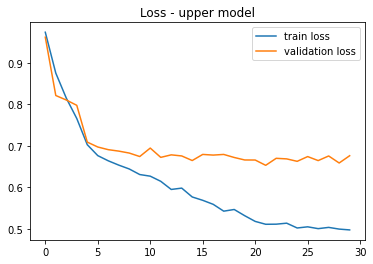

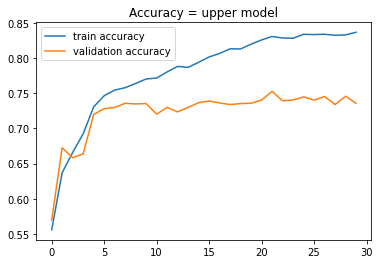

In [296]:
# plot the accuracies and loss of trainset and val set
plt.figure()
length = len(history.history["loss"])
plt.plot(np.arange(length),history.history["loss"],label = "train loss")
plt.plot(np.arange(length),history.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("Loss - upper model")


plt.figure()
length = len(history.history["accuracy"])
plt.plot(np.arange(length),history.history["accuracy"],label = "train accuracy")
plt.plot(np.arange(length),history.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("Accuracy = upper model")

In [ ]:
model_upper.load_weights("upper_model/cp.ckpt")
num_epochs = 10
model_upper.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history = model_upper.fit(train_upper,
                    epochs=num_epochs,
                    validation_data=val_upper,
                    verbose=1,
                    callbacks = [checkpointing])

Epoch 1/10
275/275 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.7638
Epoch 1: val_loss did not improve from 0.65241
275/275 [==============================] - 82s 223ms/step - loss: 0.6358 - accuracy: 0.7638 - val_loss: 0.7508 - val_accuracy: 0.6879
Epoch 2/10
275/275 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.7659
Epoch 2: val_loss did not improve from 0.65241
275/275 [==============================] - 61s 222ms/step - loss: 0.6105 - accuracy: 0.7659 - val_loss: 0.6890 - val_accuracy: 0.7253
Epoch 3/10
275/275 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7826
Epoch 3: val_loss did not improve from 0.65241
275/275 [==============================] - 61s 223ms/step - loss: 0.5871 - accuracy: 0.7826 - val_loss: 0.7238 - val_accuracy: 0.7043
Epoch 4/10
275/275 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.7878
Epoch 4: val_loss did not improve from 0.65241
275/275 [=================

##Evaluate the perfromance of the upper model 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
label_pred = np.argmax(model_upper.predict(val_upper),axis = 1)
label_true = val_upper.classes

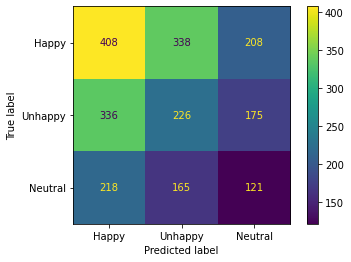

In [ ]:
confusion_matrix = confusion_matrix(label_true,label_pred)
confusion_plt = ConfusionMatrixDisplay(confusion_matrix,display_labels = class_names)
confusion_plt.plot()
plt.show()

In [ ]:
val_upper[0][0].shape

(32, 48, 48, 3)

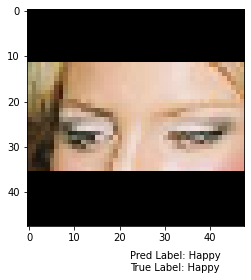

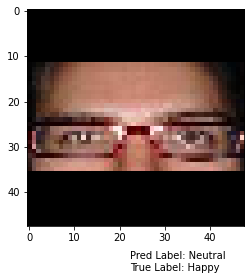

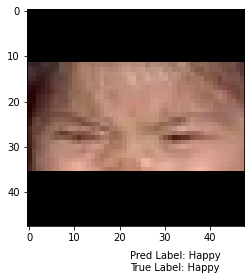

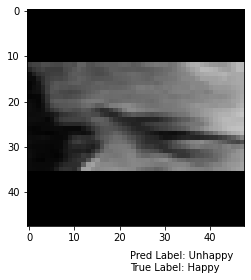

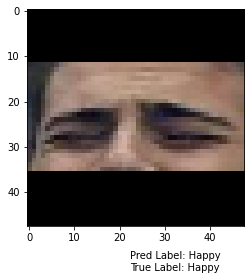

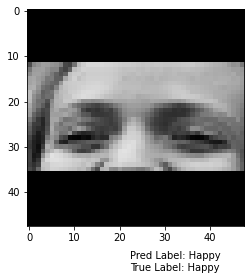

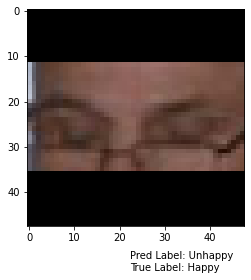

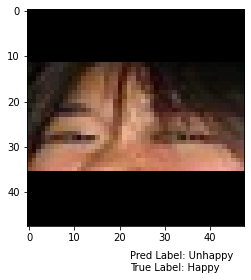

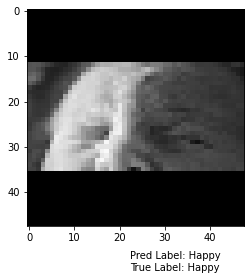

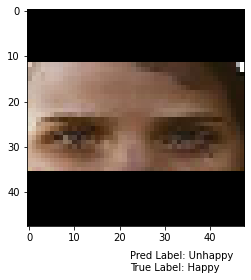

In [ ]:
for i in range(0,10):
  plt.figure()
  plt.imshow(val_upper[4][0][i])
  plt.figtext(0.5,0.01,"Pred Label: "+class_names[label_pred[4*32+i]])
  plt.figtext(0.5,-0.03,"True Label: "+class_names[label_true[4*32+i]])

In [ ]:
val_upper[0][0][0].shape

(48, 48, 3)

In [ ]:
model_upper.save_weights("model_upper.h5")

## Use openCV2 to test the model(demo)

In [ ]:
model_upper.load_weights("/content/upper_model/cp.ckpt")

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
frame = cv2.imread("/content/photo.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#height, width , channel = gray.shape
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
#try:
for (x,y,w,h) in faces:
    #cv2.rectangle(frame, (x,y),(x+w, y+(int(h/2))), color = [255,0,0],thickness =  2)
    
    roi= frame[y:y+int(h/2),x:x+w]
    
    roi =cv2.resize(roi,(48,24))
    roi = cv2.flip(roi,1)
    cv2_imshow(roi)
    

    image_pixels = np.asarray(roi)

    image_pixels = np.expand_dims(image_pixels, axis = 0)
    image_pixels = image_pixels.astype("float")/255.

    image_pixels = tf.convert_to_tensor(image_pixels)
    image_pixels = tf.image.resize_with_pad(image_pixels,48,48)
    

    predictions = model_upper.predict(image_pixels)
    max_index = np.argmax(predictions[0])
    print(predictions[0])
    emotion_detection = class_names
    emotion_prediction = emotion_detection[max_index]
    print(emotion_prediction)
#except:



[0.9131063  0.03994816 0.04694554]
Happy


In [ ]:
# how happy is oour class
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
frame = cv2.imread("/content/photo.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#height, width , channel = gray.shape
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
#try:
for (x,y,w,h) in faces:
    #cv2.rectangle(frame, (x,y),(x+w, y+(int(h/2))), color = [255,0,0],thickness =  2)
    
    roi= frame[y:y+int(h/2),x:x+w]
    cv2_imshow(roi)
    roi =cv2.resize(roi,(48,24))
    

    image_pixels = np.asarray(roi)

    image_pixels = np.expand_dims(image_pixels, axis = 0)
    image_pixels = image_pixels.astype("float")/255.

    image_pixels = tf.convert_to_tensor(image_pixels)
    image_pixels = tf.image.resize_with_pad(image_pixels,48,48)
    

    predictions = model_upper.predict(image_pixels)
    max_index = np.argmax(predictions[0])
    print(predictions[0])
    emotion_detection = class_names
    emotion_prediction = emotion_detection[max_index]
    print(emotion_prediction)
#except:

# Training using the lower part of the image

###Crop the Images

In [ ]:
side_length = 48
lower_mapfunc = lambda threeD_array: tf.image.resize_with_pad(tf.image.crop_to_bounding_box(threeD_array,side_length//2,0,side_length//2,side_length),48,48)
# Use Image data generator to preprocess images 
datagen_lower = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    preprocessing_function = lower_mapfunc,
    validation_split=0.2)

In [ ]:
class_names = ["Happy","Unhappy","Neutral"]
train_lower = datagen_lower.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "training")
val_lower = datagen_lower.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "validation")

Found 8786 images belonging to 3 classes.
Found 2195 images belonging to 3 classes.


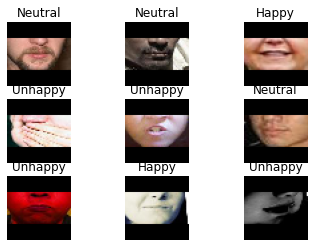

In [ ]:
for i in range(1,10):
  ax = plt.subplot(3,3,i)
  ax.imshow(train_lower[0][0][i+20])
  index = int(np.argmax(train_lower[0][1][i+20]))
  ax.set_title(class_names[index])
  plt.axis("off")

###Train lower model with fine tuning

In [ ]:
# fine tuning
model_lower = emotion_classification_model(num_classes = 7)
opt_transfer = Adam(0.001)
model_lower.load_weights("base_model/cp.ckpt")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_68 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_69 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [ ]:
x = model_lower.layers[-1].output
predictions = Dense(3, activation = "softmax")(x)
model_lower = Model(inputs = model_lower.input, outputs = predictions)

In [ ]:
# check pointing callback
checkpoint_path = "lower_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)

In [ ]:
# create a learning rate scheduler
def multistep_scheduler3(epochs, lr):
  if epochs==4 :
    lr = lr*0.1
  if epochs == 20:
    lr = lr/5
  return lr
multistep_lr3 = tf.keras.callbacks.LearningRateScheduler(multistep_scheduler3)

In [ ]:
model_lower.compile(loss='categorical_crossentropy', optimizer=opt_transfer, metrics=['accuracy'])
num_epochs = 30
history = model_lower.fit(train_lower,
                    epochs=num_epochs,
                    validation_data=val_lower,
                    verbose=1,
                    callbacks = [multistep_lr3, checkpointing])

Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.6175
Epoch 1: val_loss improved from inf to 0.92806, saving model to lower_model/cp.ckpt
275/275 [==============================] - 64s 226ms/step - loss: 0.9611 - accuracy: 0.6175 - val_loss: 0.9281 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 0.8625 - accuracy: 0.6545
Epoch 2: val_loss improved from 0.92806 to 0.81511, saving model to lower_model/cp.ckpt
275/275 [==============================] - 61s 224ms/step - loss: 0.8625 - accuracy: 0.6545 - val_loss: 0.8151 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.6694
Epoch 3: val_loss improved from 0.81511 to 0.78413, saving model to lower_model/cp.ckpt
275/275 [==============================] - 85s 309ms/step - loss: 0.7853 - accuracy: 0.6694 - val_loss: 0.7841 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 4/30


Text(0.5, 1.0, 'Accuracy - lower model')

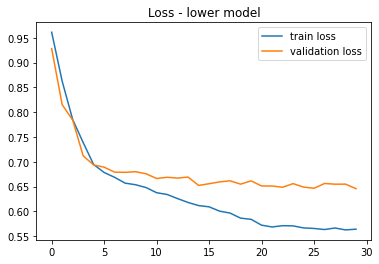

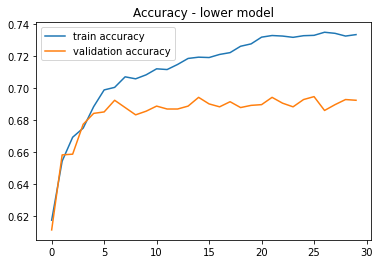

In [ ]:
# plot the accuracies and loss of trainset and val set
plt.figure()
length = len(history.history["loss"])
plt.plot(np.arange(length),history.history["loss"],label = "train loss")
plt.plot(np.arange(length),history.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("Loss - lower model")


plt.figure()
length = len(history.history["accuracy"])
plt.plot(np.arange(length),history.history["accuracy"],label = "train accuracy")
plt.plot(np.arange(length),history.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("Accuracy - lower model")

In [ ]:
model_lower.save_weights("model_lower.h5")

### Evaluation of the lower model

In [ ]:
model_lower.predict(val_lower[0][0][0])

array([[0.90966594, 0.04164958, 0.04868458],
       [0.90998447, 0.04149029, 0.04852533],
       [0.9099892 , 0.04148789, 0.04852292],
       [0.90996   , 0.04150246, 0.0485375 ],
       [0.9099795 , 0.04149276, 0.0485278 ],
       [0.07729856, 0.562254  , 0.3604474 ],
       [0.07729859, 0.562254  , 0.36044747],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.9099828 , 0.0414911 , 0.04852613],
       [0.9099892 , 0.04148789, 0.04852292],
       [0.9098296 , 0.04156763, 0.04860267],
       [0.90998656, 0.04148923, 0.04852426],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.07732068, 0.562233  , 0.36044633],
       [0.07729852, 0.5622541 , 0.36044744],
       [0.9099892 , 0.04148789, 0.04852292],
       [0.07861561, 0.56100273, 0.3603816 ],
       [0.07731608, 0.5622374 , 0.36044654],
       [0.

In [ ]:
val_lower[0][1][0]

array([0., 1., 0.], dtype=float32)

In [ ]:
label_pred = np.argmax(model_lower.predict(val_lower),axis = 1)
label_true = val_lower.classes

In [ ]:
class_names = ["Happy","Unhappy","Neutral"]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

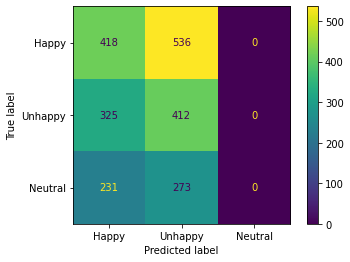

In [ ]:
confusionmatrix = confusion_matrix(label_true,label_pred)
confusion_plt = ConfusionMatrixDisplay(confusionmatrix,display_labels = class_names)
confusion_plt.plot()
plt.show()

In [ ]:
accuracy_score(label_true,label_pred)

0.37813211845102507

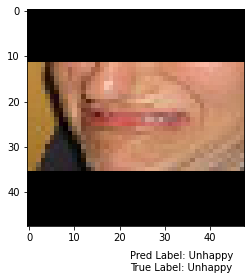

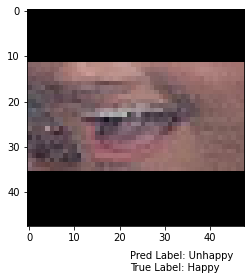

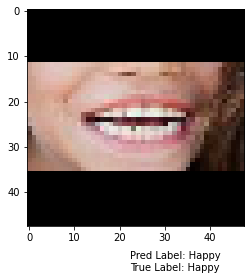

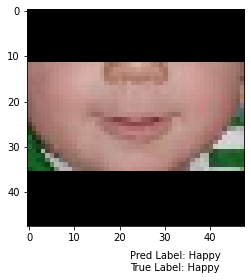

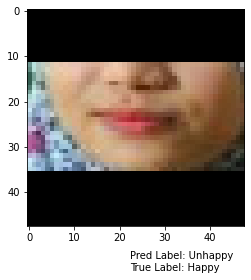

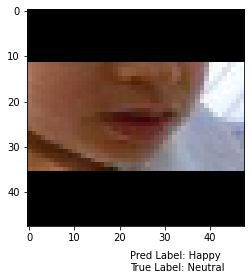

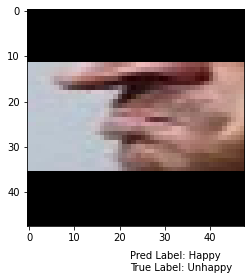

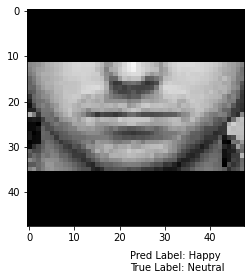

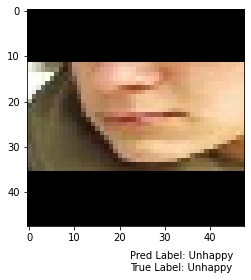

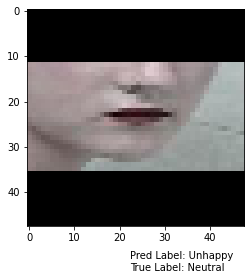

In [ ]:
for i in range(0,10):
  plt.figure()
  plt.imshow(val_lower[0][0][i])
  plt.figtext(0.5,0.01,"Pred Label: "+class_names[label_pred[i]])
  plt.figtext(0.5,-0.03,"True Label: "+class_names[np.argmax(val_lower[0][1][i])])

#Train complete faces with finetuing

###Train the model

In [ ]:
# Use Image data generator to preprocess images 
datagen_complete = ImageDataGenerator( 
    rescale=1./255,
    horizontal_flip = True,
    validation_split=0.2)

In [ ]:
class_names = ["Happy","Unhappy","Neutral"]
train_complete = datagen_complete.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "training")
val_complete = datagen_complete.flow_from_directory("/content/facial_expression_dataset_combined/train",target_size = [48,48],subset = "validation")

Found 8786 images belonging to 3 classes.
Found 2195 images belonging to 3 classes.


In [ ]:
# fine tuning
model_complete = emotion_classification_model(num_classes = 7)
opt_transfer = Adam(0.001)
model_complete.load_weights("base_model/cp.ckpt")

x = model_complete.layers[-1].output
predictions = Dense(3, activation = "softmax")(x)
model_complete = Model(inputs = model_complete.input, outputs = predictions)

# check pointing callback
checkpoint_path = "complete_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)


# create a learning rate scheduler
def multistep_scheduler4(epochs, lr):
  if epochs==15 :
    lr = lr*0.1
  if epochs == 40:
    lr = lr*0.1
  return lr
multistep_lr4 = tf.keras.callbacks.LearningRateScheduler(multistep_scheduler4)


model_complete.compile(loss='categorical_crossentropy', optimizer=opt_transfer, metrics=['accuracy'])


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_85 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_86 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [ ]:
num_epochs = 60
history = model_complete.fit(train_complete,
                    epochs=num_epochs,
                    validation_data=val_complete,
                    verbose=1,
                    callbacks = [multistep_lr4, checkpointing])

Epoch 1/60
274/275 [============================>.] - ETA: 0s - loss: 0.8078 - accuracy: 0.6726
Epoch 1: val_loss improved from inf to 0.74083, saving model to complete_model/cp.ckpt
275/275 [==============================] - 16s 52ms/step - loss: 0.8073 - accuracy: 0.6732 - val_loss: 0.7408 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 2/60
275/275 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7885
Epoch 2: val_loss improved from 0.74083 to 0.60271, saving model to complete_model/cp.ckpt
275/275 [==============================] - 14s 52ms/step - loss: 0.6623 - accuracy: 0.7885 - val_loss: 0.6027 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 3/60
274/275 [============================>.] - ETA: 0s - loss: 0.5708 - accuracy: 0.8164
Epoch 3: val_loss improved from 0.60271 to 0.59320, saving model to complete_model/cp.ckpt
275/275 [==============================] - 14s 52ms/step - loss: 0.5706 - accuracy: 0.8165 - val_loss: 0.5932 - val_accuracy: 0.7818 - lr: 0.0010
Epoch

Text(0.5, 1.0, 'Accuracy - lower model')

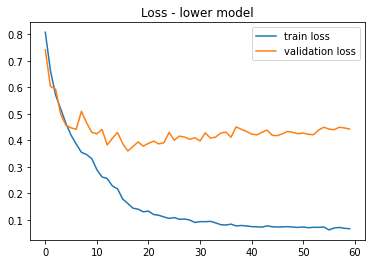

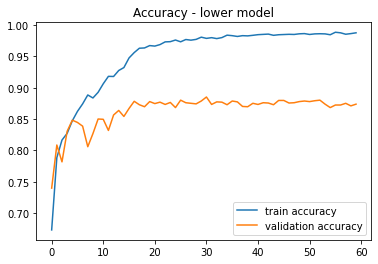

In [ ]:
# plot the accuracies and loss of trainset and val set
plt.figure()
length = len(history.history["loss"])
plt.plot(np.arange(length),history.history["loss"],label = "train loss")
plt.plot(np.arange(length),history.history["val_loss"],label = "validation loss")
plt.legend()
plt.title("Loss - complete model")


plt.figure()
length = len(history.history["accuracy"])
plt.plot(np.arange(length),history.history["accuracy"],label = "train accuracy")
plt.plot(np.arange(length),history.history["val_accuracy"],label = "validation accuracy")
plt.legend()
plt.title("Accuracy - complete model")

In [ ]:
model_complete.load_weights("/content/complete_model/cp.ckpt")
# The model stops learning afte the frist learning rate drop, so here we recover the weight of the first frop and continue training using the defualt learning rate

In [ ]:
model_complete.compile(loss='categorical_crossentropy', optimizer=opt_transfer, metrics=['accuracy'])
num_epochs = 10
history = model_complete.fit(train_complete,
                    epochs=num_epochs,
                    validation_data=val_complete,
                    verbose=1,
                    callbacks = [checkpointing])

Epoch 1/10
275/275 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9607
Epoch 1: val_loss did not improve from 0.35926
275/275 [==============================] - 16s 51ms/step - loss: 0.1457 - accuracy: 0.9607 - val_loss: 0.3771 - val_accuracy: 0.8761
Epoch 2/10
274/275 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9629
Epoch 2: val_loss did not improve from 0.35926
275/275 [==============================] - 14s 50ms/step - loss: 0.1429 - accuracy: 0.9630 - val_loss: 0.3841 - val_accuracy: 0.8747
Epoch 3/10
275/275 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9660
Epoch 3: val_loss did not improve from 0.35926
275/275 [==============================] - 14s 51ms/step - loss: 0.1324 - accuracy: 0.9660 - val_loss: 0.3740 - val_accuracy: 0.8829
Epoch 4/10
274/275 [============================>.] - ETA: 0s - loss: 0.1287 - accuracy: 0.9671
Epoch 4: val_loss did not improve from 0.35926
275/275 [====================

The model reaches its capacity

In [ ]:
model_complete.save_weights("model_complete.h5")

#Evaluation of all models

In [ ]:
test_upper = datagen_upper.flow_from_directory("/content/facial_expression_dataset_combined/test",target_size = [48,48],shuffle=False)
test_lower = datagen_lower.flow_from_directory("/content/facial_expression_dataset_combined/test",target_size = [48,48],shuffle = False)
test_complete = datagen_complete.flow_from_directory("/content/facial_expression_dataset_combined/test",target_size = [48,48],shuffle=False)

Found 2739 images belonging to 3 classes.
Found 2739 images belonging to 3 classes.
Found 2739 images belonging to 3 classes.


In [ ]:
model_complete.evaluate(test_complete)

86/86 [==============================] - 3s 33ms/step - loss: 0.4470 - accuracy: 0.8583


[0.4469572603702545, 0.8583424687385559]

In [ ]:
model_upper.evaluate(test_upper)

86/86 [==============================] - 22s 260ms/step - loss: 0.6909 - accuracy: 0.7171


[0.6908523440361023, 0.7170500159263611]

In [ ]:
model_lower.load_weights("/content/lower_model/cp.ckpt")
model_lower.evaluate(test_lower)

86/86 [==============================] - 22s 250ms/step - loss: 0.7005 - accuracy: 0.6623


[0.7004655003547668, 0.6622855067253113]

###In-depth analysis of upper and lower model

In [320]:
upper_pred =np.argmax(model_upper.predict(test_upper),axis =1)
lower_pred = np.argmax(model_lower.predict(test_lower),axis =1)

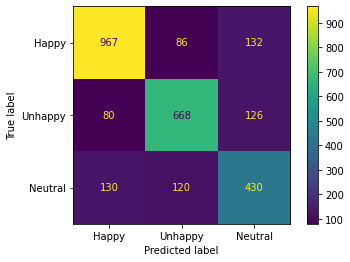

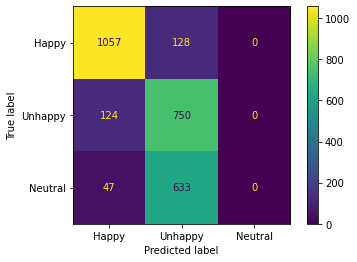

In [321]:
cf_upper = confusion_matrix (test_upper.classes,upper_pred)
cf_lower = confusion_matrix (test_lower.classes,lower_pred)
upper_plt = ConfusionMatrixDisplay(cf_upper,display_labels = class_names)
upper_plt.plot()
plt.show()

lower_plt = ConfusionMatrixDisplay(cf_lower,display_labels = class_names)
lower_plt.plot()
plt.show()



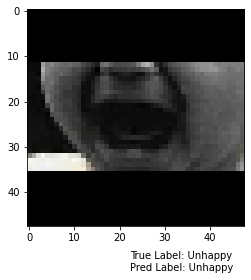

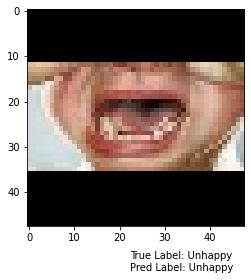

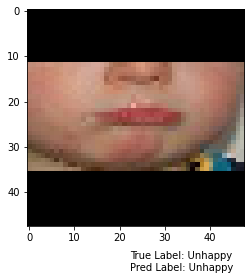

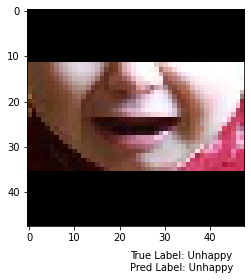

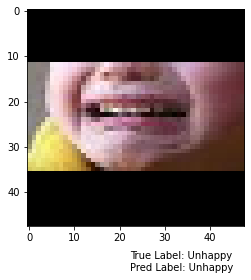

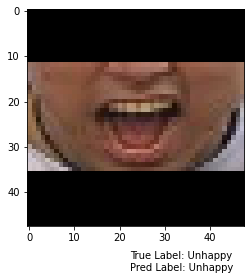

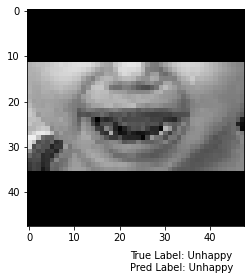

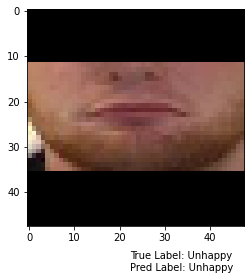

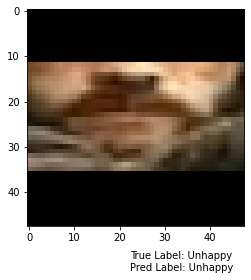

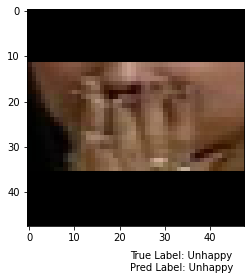

In [340]:
for i in range(0,10):
  plt.figure()
  plt.imshow(test_lower[41][0][i])
  plt.figtext(0.5,0.01,"True Label: "+class_names[test_lower.classes[41*32+i]])
  plt.figtext(0.5,-0.03,"Pred Label: "+class_names[lower_pred[41*32+i]])

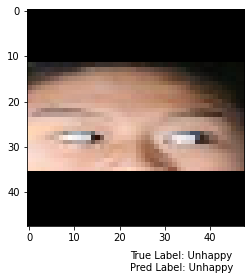

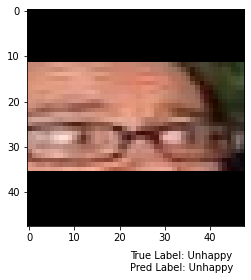

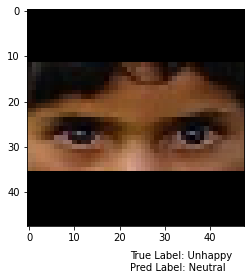

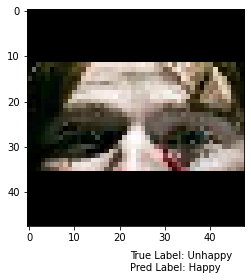

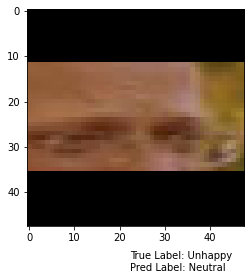

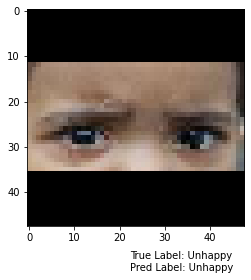

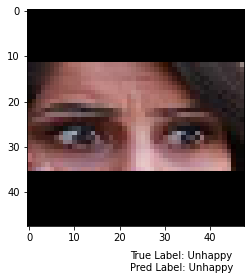

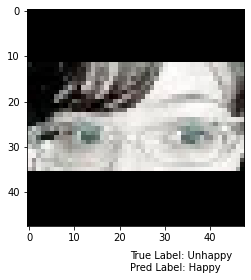

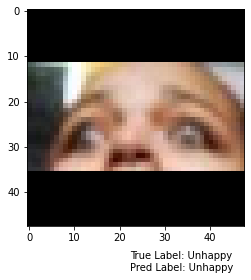

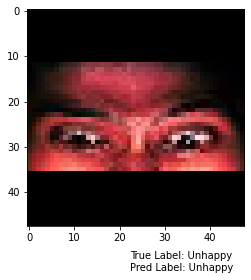

In [350]:
n = 60
for i in range(0,10):
  plt.figure()
  plt.imshow(test_upper[n][0][i])
  plt.figtext(0.5,0.01,"True Label: "+class_names[test_upper.classes[n*32+i]])
  plt.figtext(0.5,-0.03,"Pred Label: "+class_names[upper_pred[n*32+i]])

###Combine lower and upper face

In [ ]:
upper_pred = model_upper.predict(test_upper)

In [ ]:
lower_pred = model_lower.predict(test_lower)

In [ ]:
combined_pred = upper_pred+lower_pred

In [ ]:
combined_pred.shape

(2739, 3)

In [ ]:
combined_pred_temp = np.argmax(combined_pred, axis = 1)

In [ ]:
combined_pred_temp

array([2, 0, 0, ..., 2, 2, 2])

In [ ]:
accuracy_score(test_complete.classes,combined_pred_temp)

0.7933552391383717

# Download files

In [310]:
from google.colab import files

In [353]:
shutil.copy("/content/model_upper.h5","/content/gdrive/MyDrive/DS301_FinalProject/models")
shutil.copytree("/content/upper_model","/content/gdrive/MyDrive/DS301_FinalProject/models/upper_model")

'/content/gdrive/MyDrive/DS301_FinalProject/models/upper_model'

In [354]:
shutil.copy("/content/model_lower.h5","/content/gdrive/MyDrive/DS301_FinalProject/models")
shutil.copytree("/content/lower_model","/content/gdrive/MyDrive/DS301_FinalProject/models/lower_model")

'/content/gdrive/MyDrive/DS301_FinalProject/models/lower_model'

In [355]:
shutil.copy("/content/model_complete.h5","/content/gdrive/MyDrive/DS301_FinalProject/models")
shutil.copytree("/content/complete_model","/content/gdrive/MyDrive/DS301_FinalProject/models/complete_model")

'/content/gdrive/MyDrive/DS301_FinalProject/models/complete_model'

In [357]:
shutil.copy("/content/base_model.h5","/content/gdrive/MyDrive/DS301_FinalProject/models")
#shutil.copytree("/content/base_model","/content/gdrive/MyDrive/DS301_FinalProject/models/base_model")

'/content/gdrive/MyDrive/DS301_FinalProject/models/base_model.h5'